<a href="https://colab.research.google.com/github/jpatra72/Computer-Vision/blob/main/3D_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries




In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import cv2
import os
from scipy import signal
# from attrdict import AttrDict

## Helper Functions

In [2]:
def load_data(d_name):
    """ Load images and matches.
    
    Args:
        d_name: primary name of the image
        
    Returns:
        img0, img1: Images
        P0, P1: 3X4 camera matrix
    """
    img0 = imageio.imread(f'{d_name}1.jpg')
    img1 = imageio.imread(f'{d_name}2.jpg')
    P0 = np.loadtxt(f'{d_name}1_camera.txt')
    P1 = np.loadtxt(f'{d_name}2_camera.txt')
    return img0, img1, P0, P1

def plot_multiple(images, titles=None, colormap='gray', 
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
    
def draw_keypoints(img, x):
    img = img.copy()
    for p, color in zip(x.T, colors):
        cv2.circle(img, (int(p[0]), int(p[1])), thickness=2, radius=1, color=color)
    return img
    
def draw_point_matches(img0, img1, x0, x1, color_mask=None):
    result = np.concatenate([img0, img1], axis=1)
    img0_width = img0.shape[1]
    
    if color_mask is None:
        color_mask = np.ones(x0.shape[1], dtype=bool)
        
    for p0, p1, c_flag in zip(x0.T, x1.T, color_mask):
        p0x, p0y = int(p0[0]), int(p0[1])
        p1x, p1y = int(img0_width + p1[0]), int(p1[1])
        color = (0, 255, 0) if c_flag else (255, 0, 0)
        cv2.line(result, (p0x, p0y), (p1x, p1y),
                 color=color, thickness=1, lineType=cv2.LINE_AA)
    return result

def random_colors(n_colors):
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, n_colors)
    colors = plt.cm.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return colors*255

colors = random_colors(1000)

def draw_line(img, l):
    if abs(l[0]) < abs(l[1]):
        # More horizontal
        slope = -l[0] / l[1]
        intercept = -l[2] / l[1]
        xs = np.array([0, img.shape[1]])
        ys = intercept + slope * xs
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=(0, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    else:
        # More vertical
        slope = -l[1] / l[0]
        intercept = -l[2] / l[0]
        ys = np.array([0, img.shape[0]])
        xs = intercept + slope * ys
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=(0, 255, 255), thickness=1, lineType=cv2.LINE_AA)

def draw_points_and_epipolar_lines(img, points, lines):
    """
    Args:
        img: First or second image
        x: 3xN matrix of points (on the same image)
        l: 3xN matrix of lines (on the same image)
    """
    points = points[:2] / points[2]  # Normalize
    img = img.copy()
    
    for l in lines.T:
        draw_line(img, l)

    for (x,y), color in zip(points.T, colors):
        cv2.circle(img, (int(x), int(y)), thickness=2, radius=1, color=color)

    return img

def vector_to_skew(vec):
    return np.array([[0,      -vec[2], vec[1]],
                     [ vec[2], 0,     -vec[0]],
                     [-vec[1], vec[0], 0]])

# Fundamental Matrix Estimation

In this exercise, we will use the eight-point algorithm presented in the lecture in order to estimate the fundamental matrix between a pair of images. The overall workflow will be very similar to how we estimated the homography matrix in Exercise 3. The main difference is that a homography can only be used either when the scene is planar (with unrestricted camera transformation between the images) *or* when the camera is purely rotated but not translated (for unrestricted scene structure). If none of these conditions hold (non-planar scene with camera translation), we need to use the more general model represented by the fundamental matrix.


We will use a slightly simpler version of the algorithm here than the one presented in the lecture. Let's first assume that we are given a list of perfect correspondences $x = (u,v,1)^T$ and
$x′ = (u′, v′, 1)^T$ (in the code, we use `x0` for $x'$ and `x1` for $x$), so that we don’t have to deal with outliers. The fundamental matrix constraint states that each such correspondence must fulfill the equation

$$
x'^T\mathrm{F}x = 0
$$

We can reorder the entries of the matrix to transform this into the following equation

$$
[\begin{matrix}{u'u} & {u'v} & u' & {v'u} & {v'v} & v' & u & v & 1\end{matrix}] \left[\begin{matrix}F_{11} \cr F_{12} \cr F_{13} \cr F_{21} \cr F_{22} \cr F_{23} \cr F_{31} \cr F_{32} \cr F_{33}\end{matrix}\right] = 0
$$

By stacking $N ≥ 8$ of those equations in a matrix $\mathrm{A}$, we obtain the matrix equation

$$
\mathrm{Af} = 0 \tag{3}
$$

$$
\left[\begin{matrix}{u_1'u_1} & {u_1'v_1} & u_1' & {v_1'u_1} & {v_1'v_1} & v_1' & u_1 & v_1 & 1 \cr {u_2'u_2} & {u_2'v_2} & u_2' & {v_2'u_2} & {v_2'v_2} & v_2' & u_2 & v_2 & 1 \cr . & . & . & . & . & . & . & . & . \cr . & . & . & . & . & . & . & . & . \cr . & . & . & . & . & . & . & . & . \cr {u_N'u_N} & {u_N'v_N} & u_N' & {v_N'u_N} & {v_N'v_N} & v_N' & u_N & v_N & 1\end{matrix}\right] \left[\begin{matrix}F_{11} \cr F_{12} \cr . \cr . \cr. \cr F_{33}\end{matrix}\right] = \left[\begin{matrix}0 \cr 0 \cr . \cr . \cr . \cr 0\end{matrix}\right] \tag{4}
$$

which can be easily solved by Singular Value Decomposition (SVD), as shown in Exercise 3. Applying SVD to $\mathrm{A}$ yields the decomposition $\mathrm{A = UDV}^⊤$. The homogeneous least-squares solution corresponds to the least singular vector, which is given by the last column of $\mathrm{V}$.

In the presence of noise, the matrix $\mathrm{F}$ estimated this way will, however, not satisfy the rank-2 constraint. This means that there will be no real epipoles through which all epipolar lines pass, but the intersection will be spread out over a small region. In order to enforce the rank-2 constraint, we therefore apply SVD to $\mathrm{F}$ and set the smallest singular value $D_{33}$ to zero.

The reconstructed matrix will now satisfy the rank-2 constraint, and we can obtain the epipoles as

$$
\mathrm{Fe_1} = 0
$$

$$
\mathrm{F^T e_0} = 0
$$

by setting $\mathrm{e_1} = \frac{[V_{13}, V_{23}, V_{33}]}{V_{33}}$ and $\mathrm{e_0} = \frac{[U_{13}, U_{23}, U_{33}]}{U_{33}}$.
  
Similarly, for the points $\mathrm{x,x′}$, we can obtain the epipolar lines $\mathrm{l′ = Fx}, \mathrm{l = F^⊤x′}$ in the other image. Note that in projective geometry, a line is also defined by a single 3D vector. This can be easily seen by starting with the standard Euclidean formula for a line

$$
ax + by + c = 0
$$

and using the fact that the equation is unaffected by scaling to apply it to the homogeneous point $\mathrm{x = (X,Y,W)}$. Thus, we arrive at

$$
aX + bY + cW = 0
$$

$$
\mathrm{l}^Tx = x^T\mathrm{l} = 0
$$

The parameters of the line are easily interpreted: $−a/b$ is the slope, $−c/a$ is the $x$-intercept, and $−c/b$ is the $y$-intercept.

If you are not familiar with homogenuous coordinates or perspective geometry, have a look at following tutorials:
http://www.maths.lth.se/matematiklth/personal/calle/datorseende13/notes/forelas2.pdf  
https://www.cse.unr.edu/~bebis/CS791E/Notes/EpipolarGeonetry.pdf  
http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/BEARDSLEY/node2.html

Write a function that implements the above algorithm to compute the fundamental matrix and the epipoles from a set of (at least 8) perfect correspondences given in the vectors x1 and x2.

In [3]:
def get_fundamental_matrix(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0.T @ F @ x1 = 0
        e0: The epipole in image 0 such that F.T  @ e0 = 0
        e1: The epipole in image 1 such that F @ e1 = 0 
    """
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    # Constraint matrix
    n_pts = x0.shape[1]
    A = np.column_stack(
        (x0[0]*x1[0], x0[0]*x1[1], x0[0], x1[0]*x0[1],
         x0[1]*x1[1], x0[1], x1[0], x1[1], np.ones(n_pts)))
    
    # SVD
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
                       
    # Enforce rank(F) = 2
    U, S, Vt = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ Vt 
    
    # Epipoles
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    
    return F, e0, e1

In order to get a quantitative estimate for the accuracy of your results, write a function `get_residual_distance` that computes the distance between points in one image and their corresponding epipolar lines (distance is positive). *Hint*: Be sure to normalize both homogeneous points (divide $(wx, wy, w)^T$ by $w$) and lines (divide $(a, b, d)^T$ by $\sqrt{a^2 + b^2}$) before computing the distance. 

In [4]:
def get_residual_distance(F, x0, x1):
    # Epipolar lines
    l0 = F @ x1
    l1 = F.T @ x0
    
    # Normalize
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    l0 = l0 / np.hypot(l0[0], l0[1])
    l1 = l1 / np.hypot(l1[0], l1[1])
    
    # Distance 
    d0 = np.abs(np.sum(l0 * x0, axis=0))
    d1 = np.abs(np.sum(l1 * x1, axis=0))
        
    return d0, d1

In [5]:
def get_residual_error(F, x0, x1):
    d0, d1 = get_residual_distance(F, x0, x1)
    return 0.5 * (np.mean(d0) + np.mean(d1))

## Normalization
As explained in the lecture, we need to take care of normalizing the points in order to make sure the estimation problem is well conditioned. Write a function `normalize_points` that normalizes the given list of 2D points (in homogenuous coordinates) `x` by first shifting their origin to the centroid and then scaling them such that their mean distance from the origin is $\sqrt{2}$. Since the input points are homogeneous, pay attention to divide them by their last component before processing them. The function should return both the transformed points and the $3 × 3$ transformation matrix $\mathrm{T}$.

In [6]:
def normalize_points(x):
    """
    Args:
        x: 3xN arrays of N homogenous points in 2D
        
    Return:
        x_trans: 3xN matrix of transformed points
        T: the 3x3 transformation matrix, points_trans = T * points
    """
    # Shift origin to centroid
    x = x / x[2]
    center = np.mean(x, axis=1)
    T_center = np.array([[1, 0, -center[0]],
                         [0, 1, -center[1]],
                         [0, 0, 1]])
    x_trans = T_center @ x

    # Normalize the distances
    scale = np.sqrt(2) / np.mean(np.linalg.norm(x_trans[:2], axis=0))
    T_scale = np.array([[scale, 0, 0],
                        [0, scale, 0],
                        [0, 0, 1]])
    T = T_scale @ T_center
    x_trans = T @ x
    
    return x_trans, T

Now write an adapted function `get_fundamental_matrix_with_normalization` that first normalizes the input points, computes the fundamental matrix based on the normalized points, and then undoes the transformation by applying $\mathrm{F = T_0^⊤FT_1}$ before computing the epipoles.

In [7]:
def get_fundamental_matrix_with_normalization(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0'*F*x1 = 0
        e0: The epipole in image 0 such that F'*e0 = 0
        e1: The epipole in image 1 such that F*e1 = 0 
    """
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    x0_norm, T0 = normalize_points(x0)
    x1_norm, T1 = normalize_points(x1)
    F_norm, _, _ = get_fundamental_matrix(x0_norm, x1_norm)

    # Undo the transformation
    F = T0.T @ F_norm @ T1

    # Compute epipoles
    U, _, Vt = np.linalg.svd(F)
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    
    return F, e0, e1

## RANSAC
In practice, the correspondence set will always contain noise and outliers. We therefore apply RANSAC in order to get a robust estimate. It proceeds along the following steps:

1. Randomly select a (minimal) seed group of point correspondences on which to base the estimate.
2. Compute the fundamental matrix from this seed group.
3. Find inliers to this transformation.
4. If the number of inliers is sufficiently large $(≥ m)$, recompute the least-squares estimate of the fundamental matrix on all inliers.
5. Else, repeat for a maximum of k iterations.

The parameter $k$ can be chosen automatically. Suppose $w$ is the fraction of inlier correspondences and $n = 8$ correspondences are needed to define a hypothesis. Then the probability that a single sample of $n$ correspondences is correct is $w^n$, and the probability that all samples fail is $(1 − w^n)^k$. The standard strategy is thus, given an estimate for $w$, to choose $k$ high enough that this value is kept below our desired failure rate.

In the following, we will implement the different steps of the RANSAC procedure and apply it for robust estimation of the fundamental matrix.

First write a function which takes as input an estimated fundamental matrix and the full set of correspondence candidates and which returns the indices of the inliers. A point pair $x, x′$ is defined to be an inlier if the distance of $x$ to the epipolar line $\mathrm{l = F^⊤x′}$, as well as the opposite distance, are both less than some threshold $ε$.

In [8]:
def get_inliers(F, x0, x1, eps):
    d0, d1 = get_residual_distance(F, x0, x1)
    indices = np.argwhere(
            np.logical_and(d0 < eps, d1 < eps))[...,0]
    return indices

Now write a function which implements the RANSAC procedure to estimate a fundamental matrix using the normalized eight-point algorithm. For randomly sampling matches, you can use the np.random.choice() function. Here, we want to use a simple version of the algorithm that just runs for a fixed number of n_iter iterations and returns the solution with the largest inlier set.

In [9]:
def get_fundamental_matrix_with_ransac(x0, x1, eps=10, n_iter=1000):
    """
    Args:
        x0, x1: 3xN arrays of N homogenoous points in 2D
        eps: Inlier threshold
        n_iter: Number of iterations
    
    Return:
        F: The 3x3 fundamental martix such taht x2'*F*x1 = 0
        e0: The epipole in image 1 such that F'*e0 = 0
        e1: The epipole in image 2 such that F*e1 = 0 
        inlier_indices: Indices of inlier
    """
    n_pts = x1.shape[1]
    n_sample = 8
    
    indices = np.arange(n_pts)
    best_inlier_indices = []

    for i in range(n_iter):
        # Randomly select seed group of points
        sample_indices = np.random.choice(indices, size=n_sample, replace=True)
        x0_sample = x0[:, sample_indices]
        x1_sample = x1[:, sample_indices]

        # Compute transformation
        F, e0, e1 = get_fundamental_matrix_with_normalization(x0_sample, x1_sample)

        # Find inliers
        inlier_indices = get_inliers(F, x0, x1, eps)        
        if len(inlier_indices) > len(best_inlier_indices):
            best_inlier_indices = inlier_indices
            
    if len(best_inlier_indices) < 8:
        raise RuntimeError('Too few inliers found.')
            
    # Estimate fundamental matrix again with all inliers
    F, e0, e1 = get_fundamental_matrix_with_normalization(
            x0[:, best_inlier_indices], x1[:, best_inlier_indices])
    
    return F, e0, e1, best_inlier_indices

## Harris points
We can use a keypoint extractor and descriptor to find matches, as in Exercise 3. You can either use code from there, or use built-in functions of OpenCV (look up how to use `cv2.BRISK_create` for example -- BRISK is a non-patented alternative of SIFT).

Write a full pipeline that does the following:
1. Load a pair of images;
2. Extract and match keypoints (clearly visualize the results);
3. Estimate the fundamental matrix (clearly visualize the results).

In [10]:
# Use this cell for the bonus question.
img0, img1, _, _ = load_data('house')     # query image, train image

# Initiate BRISK detector
brisk = cv2.BRISK_create()

# find the keypoints and descriptors with BRISK
kp0, des0 = brisk.detectAndCompute(img0,None)
kp1, des1 = brisk.detectAndCompute(img1,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des0,des1)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

The estimated fundamental matrix F is 
[[ 7.96396985e-07 -7.17850654e-06  1.11343250e-03]
 [ 4.35355003e-06  2.61022354e-06 -1.38457898e-02]
 [-2.31586219e-03  1.35926534e-02  2.30305079e-01]]
Epipole 0: [1.95678741e+03 1.73991936e+02 1.00000000e+00], epipole 1: [2.89479690e+03 4.76260627e+02 1.00000000e+00]
Fitting error: 0.4 px


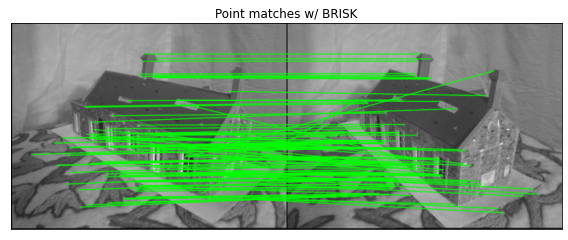

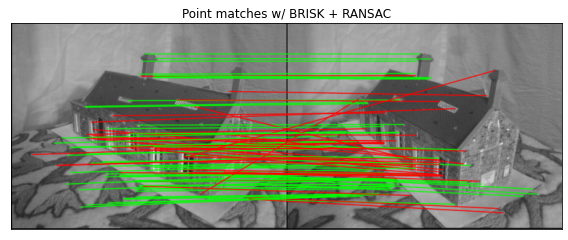

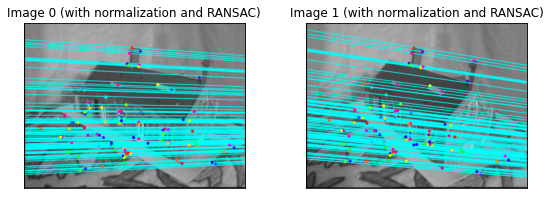

In [11]:
n_matches = 100

x0 =  np.empty([n_matches,2])
x1 =  np.empty([n_matches,2])
for idx, match in enumerate(matches[:n_matches]):
  x0[idx,:] = np.asarray(kp0[match.queryIdx].pt)
  x1[idx,:] = np.asarray(kp1[match.trainIdx].pt)

x0 = np.concatenate([x0, np.ones([n_matches, 1])], axis=1).T
x1 = np.concatenate([x1, np.ones([n_matches, 1])], axis=1).T


# Run RANSAC
eps = 1
n_iter = 1000

F, e0_ransac, e1_ransac, inlier_indices = get_fundamental_matrix_with_ransac(x0, x1, eps, n_iter)
inlier_mask_ransac = np.zeros(x0.shape[1], dtype=bool)
inlier_mask_ransac[inlier_indices] = True

print(f'The estimated fundamental matrix F is \n{F}')

# Compute residual error of the RANSAC correspondences wrt the computed fundamental matrix
x0_temp = x0[:,inlier_mask_ransac]
x1_temp = x1[:,inlier_mask_ransac]
residual_error = get_residual_error(F, x0_temp, x1_temp)

print(f'Epipole 0: {e0_ransac}, epipole 1: {e1_ransac}')
print(f'Fitting error: {residual_error:.1f} px')


## Poltting
# Plot the first n matches found using BRISK
plot_multiple([draw_point_matches(img0, img1, x0, x1)], 
              ['Point matches w/ BRISK'], imwidth=8)


# Plot the first n matches found using BRISK + normalization + RANSAC
plot_multiple([draw_point_matches(img0, img1, x0, x1, inlier_mask_ransac)], 
              ['Point matches w/ BRISK + RANSAC'], imwidth=8)
img0_result = draw_points_and_epipolar_lines(img0, x0, F @ x1)
img1_result = draw_points_and_epipolar_lines(img1, x1, F.T @ x0)
plot_multiple([img0_result, img1_result], 
              ['Image 0 (with normalization and RANSAC)', 'Image 1 (with normalization and RANSAC)'])

# Triangulation
As a final step, we want to reconstruct the observed points in 3D by triangulation. Note that just using two images, this is not possible without a calibration. You can therefore find camera matrices for each image provided in the archive *exercise5.zip*. They are stored as simple text files containing a single $3 × 4$ matrix and can be read in with the `np.loadtxt` command.

For triangulation, we use the linear algebraic approach from the lecture. Given a 2D point correspondence $\mathrm{x_1, x_2}$ in homogeneous coordinates, the 3D point location $\mathrm{X}$ is given as follows:

$$
\lambda_1\mathrm{x_1} = \mathrm{P_1X}
$$

$$
\lambda_2\mathrm{x_2} = \mathrm{P_2X}
$$

We can now build the cross-product of each point with both sides of the equation and obtain

$$
\mathrm{x_1} \times \mathrm{P_1X} = [\mathrm{x_1}_\times]\mathrm{P_1X} = 0
$$

$$
\mathrm{x_2} \times \mathrm{P_2X} = [\mathrm{x_2}_\times]\mathrm{P_2X} = 0
$$

where we used the skew-symmetrix matrices $[\mathrm{x_i}_\times]$ to replace the cross products

$$
\mathrm{a \times b} = \mathrm{[\mathrm{a}_\times]b} = \left[\begin{matrix}0&-a_z&a_y \cr a_z&0&-a_x \cr -a_y&a_x&0\end{matrix}\right]\mathrm{b}
$$

Each 2D point provides 2 independent equations for a total of 3 unknowns. We can therefore solve the overconstrained system by stacking the first two equations for each point in a matrix $\mathrm{A}$ and computing the least-squares solution for $\mathrm{AX} = 0$.

First write a function to find the centers of both cameras. Recall from the lecture that the camera centers are given by the null space of the camera matrices. They can thus be found by taking the SVD of the camera matrix and taking the last column of $\mathrm{V}$ normalized by the 4th entry.

In [12]:
def camera_center_from_projection_matrix(P):
    _, _, Vt = np.linalg.svd(P)
    center = Vt[-1, :-1] / Vt[-1,-1]
    return center

In [13]:
_, _, P0, P1 = load_data('house')
C0 = camera_center_from_projection_matrix(P0)
C1 = camera_center_from_projection_matrix(P1)

print(f'P0: {P0}')
print(f'P1: {P1}')
print(f'C0: {C0}')
print(f'C1: {C1}')

P0: [[ 1.6108033e+01  1.3704159e+01 -6.7351564e+01 -1.8838024e+02]
 [ 8.2886212e-01 -6.1257005e+01 -2.7985739e+01 -7.4190016e+00]
 [ 1.6739784e-01 -4.5720139e-02 -8.4811075e-02  5.6548906e-01]]
P1: [[ 1.0571624e+01  4.0812730e+00 -2.2538413e+01 -5.9593366e+01]
 [ 3.1827253e-01 -2.1616617e+01 -9.8820962e+00 -2.7146868e+00]
 [ 6.1142503e-02 -2.0656640e-02 -2.0701037e-02  2.5211789e-01]]
C0: [-4.82245697  1.48072657 -3.64903811]
C1: [-5.04951907  1.93166599 -4.66276516]


Now write a function *triangulate* that uses linear least-square method to triangulate the position of a matching point pair in 3D, as described above. A well suited helper function is *vector_to_skew(v)* which returns a skew symmetric matrix from the vector v with 3 elements.

In [14]:
def triangulate(x0, x1, P0, P1):
    """ Triangulate matching points.
    Args:
        x0, x1: 3xN matrices of matching points (homogeneous)
        P0, P1: 3X4 camera matrices

    Returns:
        X: 3xN matrix of points in world space
    """
    X = np.empty((4, x0.shape[1]), dtype=np.float64)
    for i in range(x0.shape[1]):
        A = np.concatenate([
            vector_to_skew(x0[:, i])[:2] @ P0,
            vector_to_skew(x1[:, i])[:2] @ P1], axis=0)
        _, _, Vt = np.linalg.svd(A, full_matrices=False)
        X[:, i] = Vt[-1, :] / Vt[-1, -1]
    return X

Write a function to compute the reprojection errors (average distance) between the observed 2D points and the projected 3D points in the two images. 

In [15]:
def get_reprojection_error(X, x, P):
    x_p = P @ X
    res = x - x_p / x_p[2, :]
    distance = np.hypot(res[0, :], res[1, :])
    return np.mean(distance)

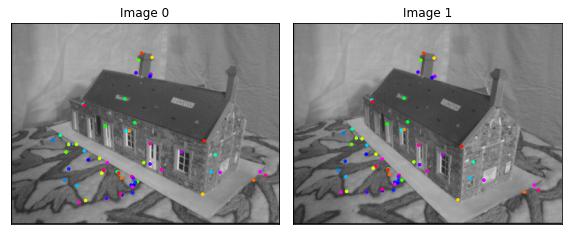

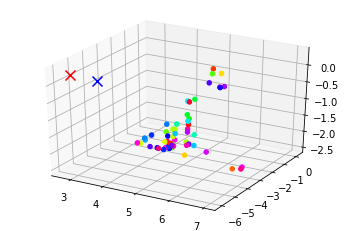

Reprojection error: 0.3 px


In [16]:
def plot_3d_reconstruction(X, C0, C1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    c = colors[:X.shape[1]]/255
    ax.scatter(X[0], X[1], X[2], c=c, alpha=1)
    ax.scatter(C0[0], C0[1], C0[2], color='red', s=100, marker='x')
    ax.scatter(C1[0], C1[1], C1[2], color='blue', s=100, marker='x')
    plt.show()

x0 = x0_temp
x1 = x1_temp

X = triangulate(x0, x1, P0, P1)
error0 = get_reprojection_error(X, x0, P0)
error1 = get_reprojection_error(X, x1, P1)
error = 0.5 * (error0 + error1)

# Rotate the visualization to be more recognizable.
U,S,Vt = np.linalg.svd(P0[:3,:3], full_matrices=False)
rot = U @ Vt
rot = np.array([[1,0,0], [0,0,1], [0,-1,0]]) @ rot

plot_multiple([draw_keypoints(img0, x0), draw_keypoints(img1, x1)], 
              ['Image 0', 'Image 1'])
plot_3d_reconstruction(rot @ X[:3]/X[3], rot @ C0, rot @ C1)
print(f'Reprojection error: {error:.1f} px')